#Questions
## Problem formulation:
1- Define the problem.

This is a binary classification Task.
It is a binary classification problem based on the graph data.
The goal is to check whether a chemical compound structure is Anti lung cancer or not.

2 What is the input? 

The data is presented in the form of a graph that depicts the compound's chemical structure. Each data sample includes information on the atoms in the molecule as well as the connections between them. The atoms and connections are the inputs features of this problem.

3- What is the output? 

Class of 0 or 1 identifying if the compoud is positive against non-small cell lung cancer or not.

4- What data mining function is required? 

Data splitting
Data Validation
Visualization
Data Preprocessing
Models like GNN GGNN FI-GN Edge-GN RGAT

5- What could be the challenges? 

The imbalanced data
the structure of the data
getting the suitable model

6- What is the impact? 

Many trials to be made, and upsampling the dataset

7- What is an ideal solution?

use GNN with upsampling to achieve accuracy of 86%

🌈Based on the provided template, describe the format of the input file (sdf file).

The input file is a data structure file (SDF). It contains information on a molecule's chemical composition. SDF files include information about the positions of individual atoms in a chemical molecule as well as the connections between them. The expression $$$$ distinguishes between different compounds.

Each sample/molecule begins with a header that describes the compound's name/title. Other sections include details on the amount of Atoms, the version number, and connections, among other things. The constituents of the compound are described in the atom block. The bond block block describes the compound's bonding structure. Both of these blocks are utilised in this assignment to obtain information about the compound and save it as edges and nodes. Each node represents an atom in a chemical compound.

🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

The input tensors in this network are:

data: In tokenized form, the data contains the nodes of the chemical molecule. Each compound's nodes are retrieved, then tokenized with the tokenizer, and then padded with the pad sequence method. (batch_size * max_len_nodes) is the form of each batch.where batch_size is the number of samples in the batch and max_len_nodes represents the length of tokenized nodes after padding.
 
edge: edge is the input tensor that contains information about atom connections (sum_of_all_edges,2) is the form of an edge.The batch size is represented by the sum(no. of edges of each sample) of the sum of all edges. For example, in a batch of three samples, sample 1 has 21, sample 2 has 20, and sample 3 has 40 edges. As a result, the size of the edge tensor is (81,2).
 
node2graph: It is the segmented mean input tensor, which contains information about segmented ids. Each batch has the shape (batch size*max len nodes), with batch size equaling the number of samples in the batch and max_len_nodes equaling the length of tokenized nodes after padding.


🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

dim of gnn_out: (batch_size_node_dimension,hidden layers) is the shape of the gnn_out, where batch_size_node_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). For each hidden layer, it represents the model's aggregation output.

dim of avg: The segmented mean of the gnn_out is calculated using the segmented ids. The output of gnn_out is (tokenized_vector_dimension, hidden_layers) for each sample in the batch_size. A segment id is assigned to each sample. As a result, segment_mean represents one sample with one number for each hidden_layer by taking the mean of all the output data in the gnn_out output. The avg tensor's final output is of the shape (batch_size, hidden_layer). It's a method of gathering information for each sample and presenting it as mean data.

🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

segment_mean: calculates the average of data with the same segmented ids.

reduce_mean: Given parameters, computes the mean of elements across dimensions of a tensor.

dim of pred: The final output (pred) indicates whether or not a chemical compound is active against cancer cells. (batch_size,1) is the shape of pred. As a result, the final output for each sample is a number that represents the likelihood associated with each chemical compound's activity.


🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

The default template uses the gcn_network's default option for the number of layers. As stated in the documentation, the default layer is [4]. RGCN (Graph convolution layers) is the default message passing technique . Using several gcn assists in effectively capturing all graph complexity, resulting in a better model.

In [2]:
!pip install tf2_gnn

  Using cached tf2_gnn-2.13.0.tar.gz (54 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached dpu_utils-0.6.1-py2.py3-none-any.whl (73 kB)
     ------------------------------------ 977.8/977.8 kB 547.9 kB/s eta 0:00:00
  Using cached azure_storage_blob-12.16.0-py3-none-any.whl (387 kB)
  Using cached azure_identity-1.12.0-py3-none-any.whl (135 kB)
     -------------------------------------- 77.1/77.1 kB 718.9 kB/s eta 0:00:00
  Using cached SetSimilaritySearch-1.0.1-py3-none-any.whl (14 kB)
     ------------------------------------ 267.9/267.9 kB 433.8 kB/s eta 0:00:00
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.5/1.5 MB 565.5 kB/s eta 0:00:00
     -------------------------------------- 24.4/24.4 MB 658.1 kB/s eta 0:00:00
     ------------------------------------ 895.7/895

In [7]:
!pip install imblearn

     ------------------------------------ 226.0/226.0 kB 629.0 kB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import cm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tf2_gnn.layers.gnn import GNN, GNNInput
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from matplotlib import cm
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

## Read SDF file

In [9]:
""" i used the sdf read file helper function from the gcnn template file"""
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [10]:
# Reading training and testing Data imported form kaggle competition
train_set = read_sdf('train.sdf')
training_set, validation_set = train_test_split(train_set, test_size=0.15,)
test_set  = read_sdf('test_x.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

# Data Exploration

In [27]:
#taking a first look at our data
print(train_set[1])


(['O', 'O', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  6],
       [ 0, 15],
       [ 1, 15],
       [ 2,  7],
       [ 3,  8],
       [ 4,  7],
       [ 5,  8],
       [ 6,  9],
       [ 7, 16],
       [ 8, 17],
       [ 9, 10],
       [ 9, 11],
       [10, 12],
       [10, 22],
       [11, 13],
       [11, 23],
       [12, 21],
       [12, 25],
       [13, 20],
       [13, 26],
       [14, 15],
       [14, 18],
       [14, 19],
       [16, 19],
       [16, 24],
       [17, 18],
       [17, 24],
       [20, 21],
       [22, 27],
       [23, 28],
       [25, 29],
       [26, 30],
       [27, 29],
       [28, 30]]), 0)


<ipython-input-59-e2461a1a8461>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique, counts = np.unique(np.array(train_set)[:,2], return_counts=True)


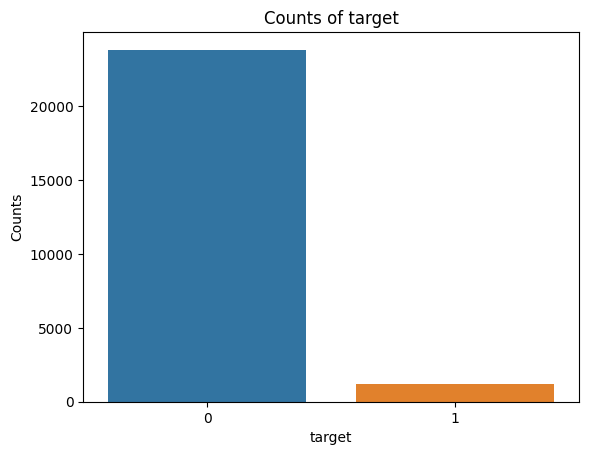

In [59]:
#check if the data is imbalanced
unique, counts = np.unique(np.array(train_set)[:,2], return_counts=True)

sns.barplot(x=unique, y=counts)
plt.xlabel('target')
plt.ylabel('Counts')
plt.title('Counts of target')
plt.show()

we can see that the data is highly imbalanced as calss 0 is 23806 and class 1 is 1218

i will try to solve this issue by making a new dataset using upsampling to see if it makes a difference in the model performance

In [11]:
#convert the data from List to DataFrame to make upsampled dataframe
df = pd.DataFrame(np.array(train_set)[:,:], columns = ['0', '1', 'target'])

C:\Users\Aly Abdelkader\AppData\Local\Temp\ipykernel_10948\4176202268.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(train_set)[:,:], columns = ['0', '1', 'target'])


In [12]:
resampling = df.copy()  #take a copy of dataframe to do resampling
class_0 = resampling[resampling['target']==0]   #specify all rows which has target zero
class_1 = resampling[resampling['target']==1]   #specify all rows which has target one
class_1_re = resample(class_1, replace=True,n_samples = len(df))   #add data records to data frame with value one to make the number of rows which has target 0 == number of rows whic has target 1
df_upsampled = pd.concat([class_0, class_1_re])    #add the new rows to the new data frame

let's see the results of upsampling

In [27]:
print("class 1: ",len(class_1_re))
print("class 0: ",len(class_0))

class 1:  25024
class 0:  23806


much better, now we can convert the dataframe back to a list for preprocessing

In [13]:
train_set_upsampled = df_upsampled.values.tolist()

In [14]:
#split the data to training and validation
train_upsampled, val_upsampled = train_test_split(train_set_upsampled, test_size=0.15)

# Data Visualization

In [39]:
colors = cm.rainbow(np.linspace(0, 1, 50))
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

we will now compare the data before and after performing upsampling

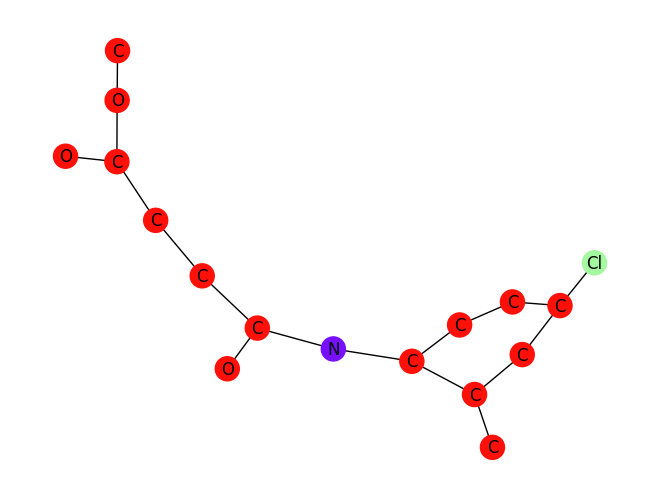

In [43]:
#before resampling
plt.clf()
visualize(train_set[20])

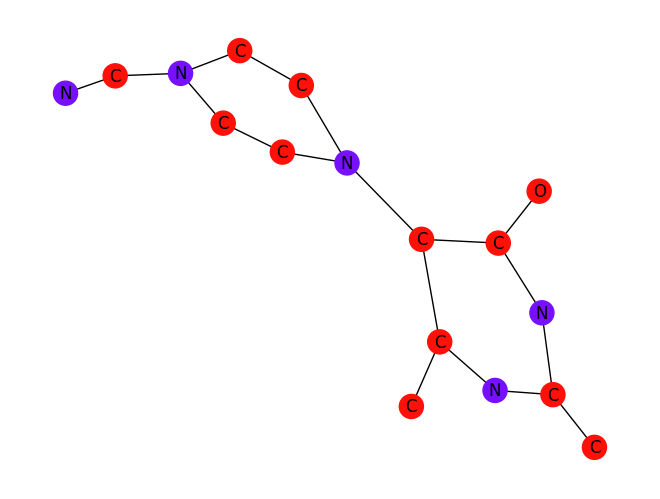

In [41]:
#After resampling
plt.clf()
visualize(train_set_upsampled[20])

#Preprocessing
we will only need to apply 

In [15]:
max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in train_upsampled]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [16]:
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [17]:
# showing one batch:
for train_batch in gen_batch(train_upsampled, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 4 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
edges
[[  0  14]
 [  0  16]
 [  1  15]
 [  1  17]
 [ 12   2]
 [  2  24]
 [  3  14]
 [  4  17]
 [  5  19]
 [  6  20]
 [  7  24]
 [  8  31]
 [ 11   9]
 [  9  19]
 [ 10  21]
 [ 10  31]
 [ 11  14]
 [ 11  15]
 [ 12  13]
 [ 12  16]
 [ 13  17]
 [ 13  22]
 [ 15  26]
 [ 16  27]
 [ 18  19]
 [ 18  20]
 [ 18  23]
 [ 20  21]
 [ 21  25]
 [ 22  29]
 [ 23  28]
 [ 24  30]
 [ 25  28]
 [ 29  33]
 [ 30  32]
 [ 32  34]
 [ 32  35]
 [ 33  36]
 [ 38  61]
 [ 38  71]
 [ 39  63]
 [ 39  72]
 [ 40  68]
 [ 41  44]
 [ 41  54]
 [ 41  57]
 [ 42  49]
 [ 42  56]
 [ 43  46]
 [ 43  65]
 [ 44  47]
 [ 44  48]
 [ 45  48]
 [ 45  50]
 [ 45  51]
 [ 46  49]
 [ 46  51]
 [ 47  53]
 [ 47  58]
 [ 49  52]
 [ 50  54]
 [ 50  6

In [18]:
# method used to plot history after training to explore model behaviour
def visualize(history):

  # generate a figure containing 3 plots displayed horizontally
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  fig.suptitle('Model Results')
  
  # first we display the training price accuracy vs. the validation price accuracy
  ax1.plot(history.history['auc'])
  ax1.plot(history.history['val_auc'])
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'validation'], loc='upper left')


  # on the last axis, we plot the training loss against the validation loss (w.r.t. price and type combined)
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['train_loss', 'validation_loss'], loc='upper left')

  plt.show() # display the figure

#Modeling
for the first 3 trials i will use the template GCN model without sampling for the first trial and with upsampling for the second trial and with edge sampling for the third trial to determine if upsampling gives better results.
## Trial 1: GCN template without sampling



In [24]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#define parameters for the model, this is where we can tune hyper parameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)
#define our model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

In [25]:
#define Adam optimizer
op = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)
#compile the model using my adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = op,
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [26]:
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
hist = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1)

Epoch 1/30


D:\Anaconda\envs\mlpr\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
D:\Anaconda\envs\mlpr\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
D:\Anac

665/665 [==============================] - 28s 38ms/step - loss: 0.2448 - auc: 0.4904 - val_loss: 0.2033 - val_auc: 0.6366
Epoch 2/30
665/665 [==============================] - 23s 35ms/step - loss: 0.1902 - auc: 0.6203 - val_loss: 0.1958 - val_auc: 0.6787
Epoch 3/30
665/665 [==============================] - 23s 34ms/step - loss: 0.1840 - auc: 0.6634 - val_loss: 0.1927 - val_auc: 0.6976
Epoch 4/30
665/665 [==============================] - 23s 34ms/step - loss: 0.1783 - auc: 0.6971 - val_loss: 0.2016 - val_auc: 0.6730
Epoch 5/30
665/665 [==============================] - 22s 33ms/step - loss: 0.1781 - auc: 0.6967 - val_loss: 0.1905 - val_auc: 0.7024
Epoch 6/30
665/665 [==============================] - 23s 34ms/step - loss: 0.1784 - auc: 0.6889 - val_loss: 0.1998 - val_auc: 0.7088
Epoch 7/30
665/665 [==============================] - 26s 39ms/step - loss: 0.1777 - auc: 0.6957 - val_loss: 0.1994 - val_auc: 0.7262
Epoch 8/30
665/665 [==============================] - 23s 35ms/step - los

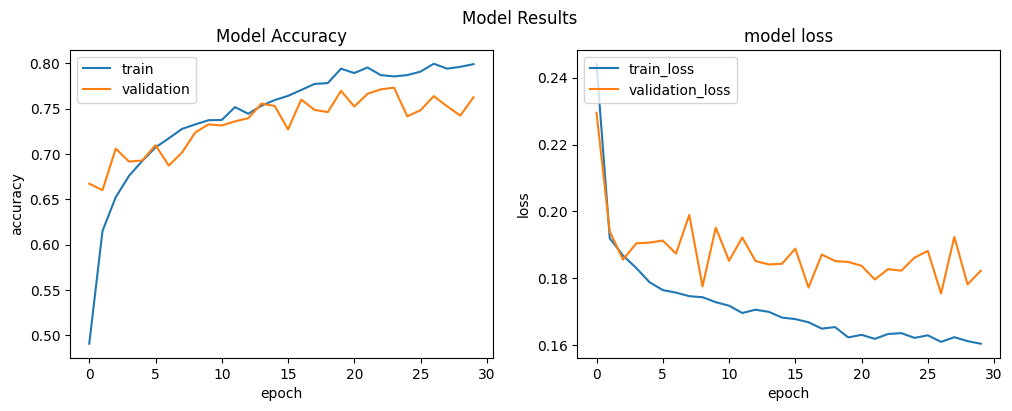

In [67]:
visualize(hist)

Observation: the model performed better than what was expected since the data was highly imbalanced with.
###AUC score on training set: 76.6%
###AUC score on validation set: 74.2%
the model still has room for improvement.

#Trial 2: GCN template with upsampling
for this trial we will fit the same model but with the sampled training set we created to see if there is a significant change in performance.

In [70]:
num_batchs = math.ceil(len(train_upsampled) / batch_size)
num_batchs_validation = math.ceil(len(val_upsampled) / batch_size)
hist = model.fit(
    gen_batch(
        train_upsampled, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        val_upsampled, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)


Epoch 1/30
1298/1298 [==============================] - 18s 14ms/step - loss: 0.5575 - auc: 0.7904 - val_loss: 0.5274 - val_auc: 0.8178
Epoch 2/30
1298/1298 [==============================] - 18s 14ms/step - loss: 0.5315 - auc: 0.8119 - val_loss: 0.5220 - val_auc: 0.8210
Epoch 3/30
1298/1298 [==============================] - 19s 14ms/step - loss: 0.5207 - auc: 0.8209 - val_loss: 0.5050 - val_auc: 0.8357
Epoch 4/30
1298/1298 [==============================] - 20s 15ms/step - loss: 0.5135 - auc: 0.8263 - val_loss: 0.4964 - val_auc: 0.8427
Epoch 5/30
1298/1298 [==============================] - 19s 15ms/step - loss: 0.5055 - auc: 0.8329 - val_loss: 0.4935 - val_auc: 0.8420
Epoch 6/30
1298/1298 [==============================] - 17s 13ms/step - loss: 0.5033 - auc: 0.8349 - val_loss: 0.4852 - val_auc: 0.8497
Epoch 7/30
1298/1298 [==============================] - 20s 15ms/step - loss: 0.4967 - auc: 0.8394 - val_loss: 0.4865 - val_auc: 0.8479
Epoch 8/30
1298/1298 [==========================

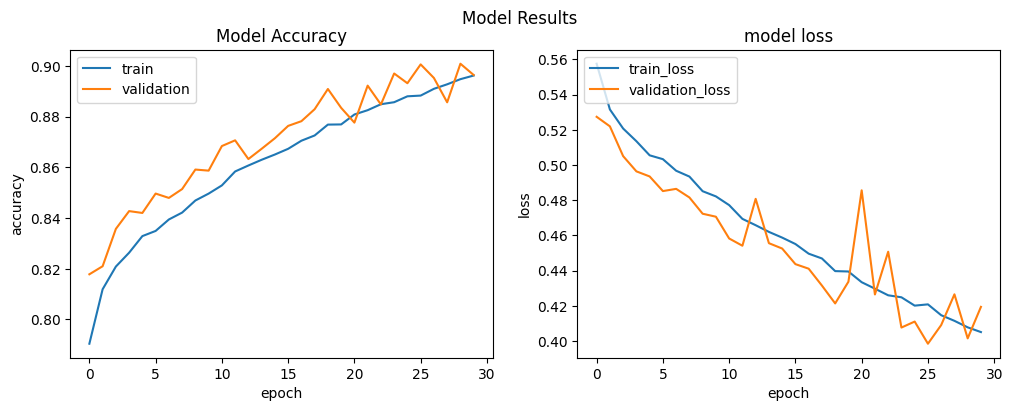

In [71]:
visualize(hist)

Observation:
the model performed signifcantly better with upsampling than without with increase of more than 10%.
###AUC score on training set: 89.62%
###AUC score on validation set: 89.24%
there are other upsampling techniques that can be used for graph data like Edge sampling

In [72]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_2.csv')

#Kaggle 80%

771/771 [==============================] - 3s 4ms/step


for the next 2 trials i will use GGNN with upsampling for the first trila and edge sampling for the second and determine the best of the two and see if the GGNN outperformes the first trial

#Trial 3: GNN with upsampling


In [74]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 64
params["num_layers"] = 10


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                      

In [75]:

model.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

hist = model.fit(
    gen_batch(
        train_set_upsampled, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        val_upsampled, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop]
)

Epoch 1/50
1298/1298 [==============================] - 76s 44ms/step - loss: 0.6242 - auc: 0.7075 - val_loss: 0.5823 - val_auc: 0.7591
Epoch 2/50
1298/1298 [==============================] - 56s 43ms/step - loss: 0.5724 - auc: 0.7709 - val_loss: 0.5566 - val_auc: 0.8034
Epoch 3/50
1298/1298 [==============================] - 55s 43ms/step - loss: 0.5290 - auc: 0.8131 - val_loss: 0.5029 - val_auc: 0.8398
Epoch 4/50
1298/1298 [==============================] - 52s 40ms/step - loss: 0.4689 - auc: 0.8590 - val_loss: 0.4207 - val_auc: 0.8896
Epoch 5/50
1298/1298 [==============================] - 55s 42ms/step - loss: 0.4166 - auc: 0.8907 - val_loss: 0.3628 - val_auc: 0.9180
Epoch 6/50
1298/1298 [==============================] - 55s 42ms/step - loss: 0.3411 - auc: 0.9265 - val_loss: 0.3262 - val_auc: 0.9388
Epoch 7/50
1298/1298 [==============================] - 52s 40ms/step - loss: 0.2909 - auc: 0.9453 - val_loss: 0.2709 - val_auc: 0.9552
Epoch 8/50
1298/1298 [==========================

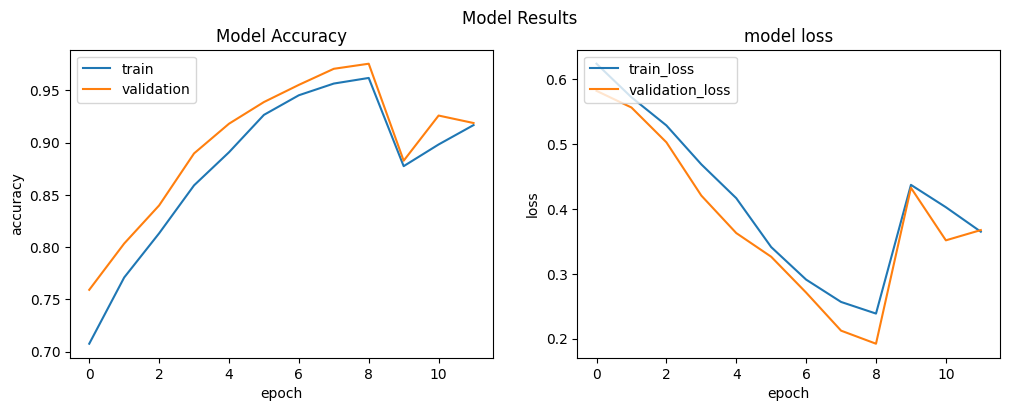

In [76]:
visualize(hist)

Observation: the model had really good performance but the loss increased at the 8th epoch lets see how it performes on the test set.

In [77]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_3.csv')

#Kaggle 86.8%

771/771 [==============================] - 8s 9ms/step


#Trial 4: GGNN with Random oversampler

In [27]:
ro = RandomOverSampler(random_state=42)
resampling['target'] = resampling['target'].astype(int)
X_resampled, y_resampled = ro.fit_resample(resampling.drop('target', axis=1), resampling['target'])
data_ro = pd.concat([X_resampled, y_resampled], axis=1)
training_ro = data_ro.values.tolist()
train_ro, val_ro = train_test_split(training_ro, test_size=0.15)

###tokenizing

In [28]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes_ro = [s[0] for s in training_ro]

#training tokenizer
token = Tokenizer(num_words = max_vocab)
token.fit_on_texts(all_nodes_ro)

In [100]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(token.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 64
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_18[0][0]']               
 da)                                                                                              
                      

In [102]:
model.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
batch_size = 64
num_batchs = math.ceil(len(train_ro) / batch_size)
num_batchs_validation = math.ceil(len(val_ro) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
hist = model.fit(
    gen_batch(
        train_ro, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        val_ro, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop]
)


Epoch 1/50
633/633 [==============================] - 33s 34ms/step - loss: 0.6297 - auc: 0.6977 - val_loss: 0.5854 - val_auc: 0.7597
Epoch 2/50
633/633 [==============================] - 17s 27ms/step - loss: 0.5550 - auc: 0.7897 - val_loss: 0.5357 - val_auc: 0.8186
Epoch 3/50
633/633 [==============================] - 19s 30ms/step - loss: 0.5159 - auc: 0.8237 - val_loss: 0.4899 - val_auc: 0.8458
Epoch 4/50
633/633 [==============================] - 17s 26ms/step - loss: 0.4786 - auc: 0.8523 - val_loss: 0.4525 - val_auc: 0.8719
Epoch 5/50
633/633 [==============================] - 16s 26ms/step - loss: 0.4325 - auc: 0.8820 - val_loss: 0.3922 - val_auc: 0.9060
Epoch 6/50
633/633 [==============================] - 17s 27ms/step - loss: 0.3811 - auc: 0.9094 - val_loss: 0.3559 - val_auc: 0.9238
Epoch 7/50
633/633 [==============================] - 16s 26ms/step - loss: 0.3289 - auc: 0.9320 - val_loss: 0.3023 - val_auc: 0.9445
Epoch 8/50
633/633 [==============================] - 17s 26ms

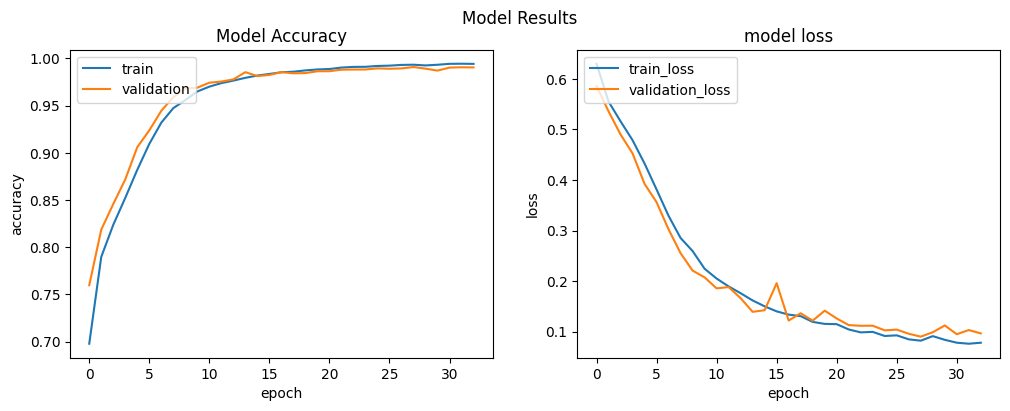

In [103]:
visualize(hist)

Observation: the same model but with random oversampler has excelent performance.
###AUC score on training set: 99.4%
###AUC score on validation set: 99%
we will see how it performs on kaggle

In [104]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_4.csv')

#Kaggle 85.6%

771/771 [==============================] - 5s 6ms/step


unfortunately it didn't out perform the last trial but it came at a close second, we will continue switching between the two samplers for every model

#Trial 5: RGAT with upsampling

In [105]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32
params["message_calculation_class"] = 'RGAT'
params["num_edge_MLP_hidden_layers"] = 16
params["num_heads"] = 16
params["num_layers"] = 6



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)


fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)

#output shape: [batch_size,1] 
#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_18/Sigmoid:0', description="created by layer 'dense_18'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []      

In [106]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model.fit(
    gen_batch(
        train_upsampled, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        val_upsampled, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=[early_stop],
    verbose=1
)
print(hist)

Epoch 1/30
633/633 [==============================] - 92s 113ms/step - loss: 0.6269 - auc: 0.6983 - val_loss: 0.5950 - val_auc: 0.7414
Epoch 2/30
633/633 [==============================] - 68s 108ms/step - loss: 0.5956 - auc: 0.7371 - val_loss: 0.5890 - val_auc: 0.7531
Epoch 3/30
633/633 [==============================] - 65s 103ms/step - loss: 0.5760 - auc: 0.7615 - val_loss: 0.5615 - val_auc: 0.7796
Epoch 4/30
633/633 [==============================] - 64s 102ms/step - loss: 0.5549 - auc: 0.7859 - val_loss: 0.5432 - val_auc: 0.7982
Epoch 5/30
633/633 [==============================] - 52s 83ms/step - loss: 0.5365 - auc: 0.8039 - val_loss: 0.5441 - val_auc: 0.8102
Epoch 6/30
633/633 [==============================] - 57s 90ms/step - loss: 0.5198 - auc: 0.8195 - val_loss: 0.5084 - val_auc: 0.8317
Epoch 7/30
633/633 [==============================] - 55s 87ms/step - loss: 0.5049 - auc: 0.8322 - val_loss: 0.4900 - val_auc: 0.8446
Epoch 8/30
633/633 [==============================] - 60s 

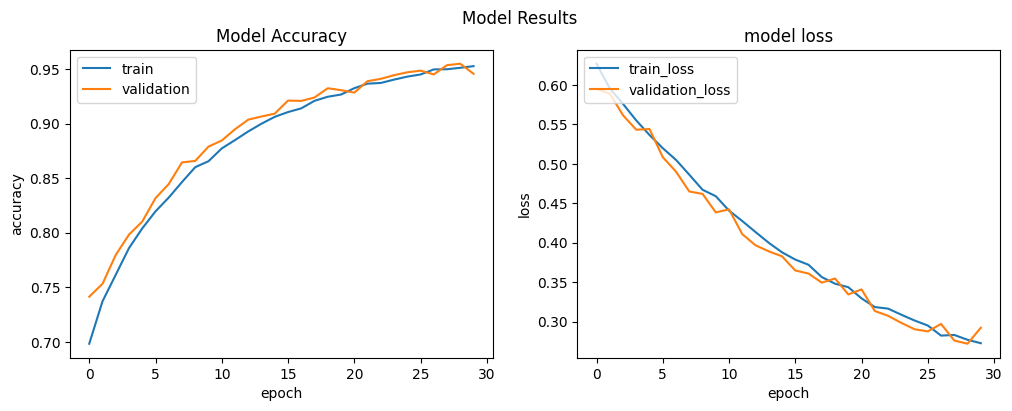

In [107]:
visualize(hist)

In [108]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_5.csv')

#Kaggle 85.6%

771/771 [==============================] - 15s 18ms/step


#Trial 6: RGAT with Random OverSampler

In [29]:
#Input layer for nodes (tokenized text data)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

#embedding layer over data with each token embedded as a vector   size vector eg. [440,75]
embeded = Embedding(token.num_words, 70)(data)

# number of graphs (number of samples)
#calculating number of samples (or min(batch_size,no._of_samples))
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the gnn layer
params["hidden_dim"] = 32
params["message_calculation_class"] = 'RGAT'
params["num_edge_MLP_hidden_layers"] = 16
params["num_heads"] = 16
params["num_layers"] = 6



#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 

#gnn output layer
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)


fc1 = Dense(64,activation='relu')(avg)
fc2 = Dense(32,activation='relu')(fc1)

#output shape: [batch_size,1] 
#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(fc2)
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []        

In [30]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
batch_size = 32
model.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model.fit(
    gen_batch(
        train_ro, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        val_ro, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=[early_stop,reduce_lr],
    verbose=1
)
print(hist)

Epoch 1/30


D:\Anaconda\envs\mlpr\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
D:\Anaconda\envs\mlpr\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
D:\Anaconda\

665/665 [==============================] - 90s 116ms/step - loss: 0.6420 - auc: 0.6740 - val_loss: 0.6089 - val_auc: 0.7448 - lr: 0.0010
Epoch 2/30
665/665 [==============================] - 73s 110ms/step - loss: 0.5960 - auc: 0.7424 - val_loss: 0.5740 - val_auc: 0.7672 - lr: 0.0010
Epoch 3/30
665/665 [==============================] - 72s 108ms/step - loss: 0.5673 - auc: 0.7737 - val_loss: 0.5829 - val_auc: 0.7636 - lr: 0.0010
Epoch 4/30
665/665 [==============================] - 73s 110ms/step - loss: 0.5522 - auc: 0.7908 - val_loss: 0.5515 - val_auc: 0.7990 - lr: 0.0010
Epoch 5/30
665/665 [==============================] - 72s 108ms/step - loss: 0.5439 - auc: 0.7985 - val_loss: 0.5696 - val_auc: 0.7821 - lr: 0.0010
Epoch 6/30
665/665 [==============================] - 73s 110ms/step - loss: 0.5294 - auc: 0.8113 - val_loss: 0.5490 - val_auc: 0.8094 - lr: 0.0010
Epoch 7/30
665/665 [==============================] - 74s 111ms/step - loss: 0.5268 - auc: 0.8147 - val_loss: 0.5261 - val_

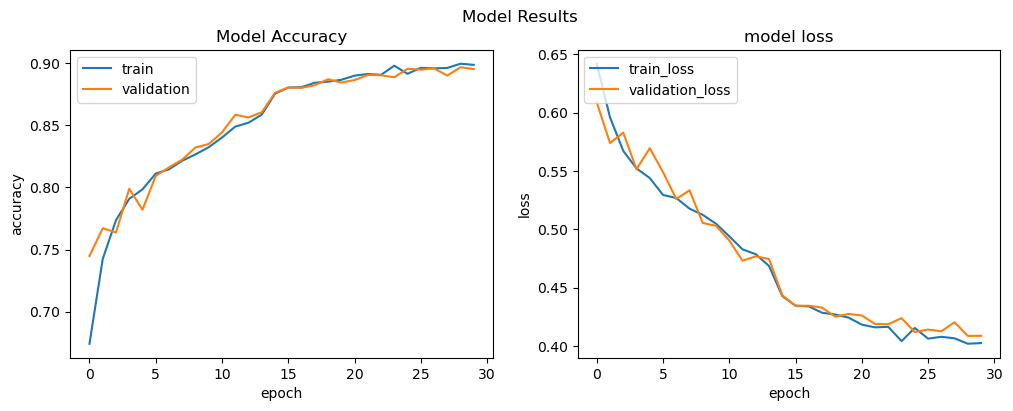

In [31]:
visualize(hist)

In [32]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_6.csv')

#Kaggle 80.9%

771/771 [==============================] - 15s 18ms/step


Observation: didn't perform as good as the past trials so we will continue.

# Trial 7: RGCN with upsampler

In [33]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 32
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                      

In [34]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model.fit(
    gen_batch(
        train_upsampl , batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        val_ro, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=[early_stop,reduce_lr],
    verbose=1
)
print(hist)

Epoch 1/30


D:\Anaconda\envs\mlpr\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_4/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_4/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_4/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
D:\Anaconda\envs\mlpr\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor 

665/665 [==============================] - 38s 52ms/step - loss: 0.6375 - auc: 0.6780 - val_loss: 0.6038 - val_auc: 0.7368 - lr: 0.0010
Epoch 2/30
665/665 [==============================] - 32s 48ms/step - loss: 0.6087 - auc: 0.7231 - val_loss: 0.6035 - val_auc: 0.7499 - lr: 0.0010
Epoch 3/30
665/665 [==============================] - 26s 39ms/step - loss: 0.5876 - auc: 0.7454 - val_loss: 0.5722 - val_auc: 0.7642 - lr: 0.0010
Epoch 4/30
665/665 [==============================] - 27s 40ms/step - loss: 0.5807 - auc: 0.7560 - val_loss: 0.5670 - val_auc: 0.7715 - lr: 0.0010
Epoch 5/30
665/665 [==============================] - 27s 41ms/step - loss: 0.5685 - auc: 0.7701 - val_loss: 0.5544 - val_auc: 0.7894 - lr: 0.0010
Epoch 6/30
665/665 [==============================] - 40s 60ms/step - loss: 0.5611 - auc: 0.7793 - val_loss: 0.5664 - val_auc: 0.7826 - lr: 0.0010
Epoch 7/30
665/665 [==============================] - 41s 61ms/step - loss: 0.5553 - auc: 0.7850 - val_loss: 0.5398 - val_auc: 0.

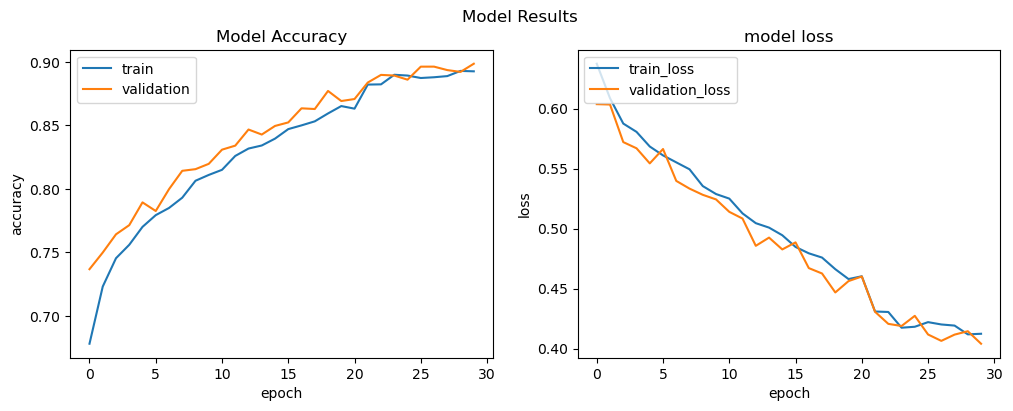

In [35]:
visualize(hist)

In [36]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_7.csv')

#Kaggle 82.7%

771/771 [==============================] - 6s 7ms/step


Observation: the model had a more decent performance than the previous trial

#Trial 8: RGCN with random OverSampler.

In [37]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(token.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 32
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_18[0][0]']               
 da)                                                                                              
                      

In [38]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model.fit(
    gen_batch(
        train_ro, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        val_ro, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=[early_stop,reduce_lr],
    verbose=1
)
print(hist)

Epoch 1/30
665/665 [==============================] - 37s 51ms/step - loss: 0.6404 - auc: 0.6753 - val_loss: 0.6118 - val_auc: 0.7386 - lr: 0.0010
Epoch 2/30
665/665 [==============================] - 27s 41ms/step - loss: 0.6098 - auc: 0.7206 - val_loss: 0.5905 - val_auc: 0.7516 - lr: 0.0010
Epoch 3/30
665/665 [==============================] - 27s 40ms/step - loss: 0.5958 - auc: 0.7382 - val_loss: 0.5841 - val_auc: 0.7554 - lr: 0.0010
Epoch 4/30
665/665 [==============================] - 25s 38ms/step - loss: 0.5812 - auc: 0.7535 - val_loss: 0.5801 - val_auc: 0.7638 - lr: 0.0010
Epoch 5/30
665/665 [==============================] - 27s 41ms/step - loss: 0.5715 - auc: 0.7653 - val_loss: 0.5775 - val_auc: 0.7685 - lr: 0.0010
Epoch 6/30
665/665 [==============================] - 29s 44ms/step - loss: 0.5721 - auc: 0.7643 - val_loss: 0.5593 - val_auc: 0.7802 - lr: 0.0010
Epoch 7/30
665/665 [==============================] - 30s 45ms/step - loss: 0.5621 - auc: 0.7778 - val_loss: 0.5623 - 

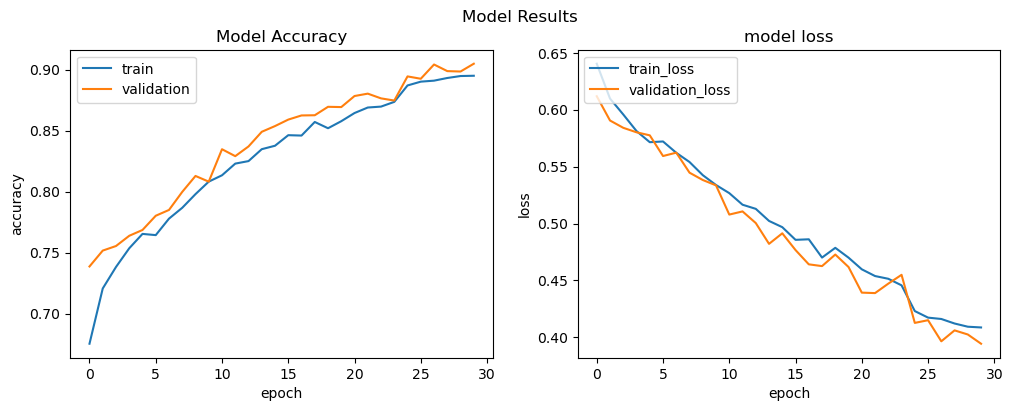

In [39]:
visualize(hist)

In [40]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_8.csv')

#Kaggle 81%

771/771 [==============================] - 6s 7ms/step


#Trial 9 : RGIN with upsampler

In [41]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGIN'
params["hidden_dim"] = 64
params["num_layers"] = 6
params["num_aggr_MLP_hidden_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_6 (TFOpLamb  ()                  0           ['input_21[0][0]']               
 da)                                                                                              
                      

In [42]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model.fit(
    gen_batch(
        train_ro, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        val_ro, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=[early_stop,reduce_lr],
    verbose=1
)
print(hist)

Epoch 1/30


D:\Anaconda\envs\mlpr\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_5_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_5_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_5_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
D:\Anaconda\envs\mlpr\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_4/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_4/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgin_4/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large 

665/665 [==============================] - 81s 116ms/step - loss: 0.6714 - auc: 0.6106 - val_loss: 0.6507 - val_auc: 0.6658 - lr: 0.0010
Epoch 2/30
665/665 [==============================] - 89s 133ms/step - loss: 0.6512 - auc: 0.6516 - val_loss: 0.6323 - val_auc: 0.6950 - lr: 0.0010
Epoch 3/30
665/665 [==============================] - 92s 138ms/step - loss: 0.6543 - auc: 0.6506 - val_loss: 0.6694 - val_auc: 0.6354 - lr: 0.0010
Epoch 4/30
665/665 [==============================] - ETA: 0s - loss: 0.6722 - auc: 0.6140
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
665/665 [==============================] - 88s 132ms/step - loss: 0.6722 - auc: 0.6140 - val_loss: 0.6594 - val_auc: 0.6479 - lr: 0.0010
Epoch 5/30
665/665 [==============================] - 93s 140ms/step - loss: 0.6637 - auc: 0.6328 - val_loss: 0.6606 - val_auc: 0.6579 - lr: 2.0000e-04
Epoch 6/30
665/665 [==============================] - ETA: 0s - loss: 0.6627 - auc: 0.6330
Epoch 6: ReduceLROn

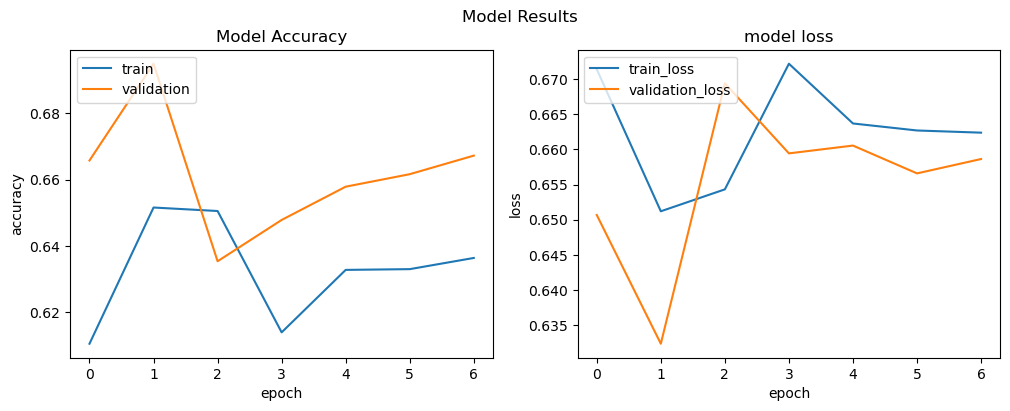

In [43]:
visualize(hist)

In [44]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_9.csv')

#Kaggle 66.6%

771/771 [==============================] - 12s 15ms/step


# Trial 10: RGIN with Random Oversampler

In [45]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(token.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGIN'
params["hidden_dim"] = 64
params["num_layers"] = 6
params["num_aggr_MLP_hidden_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_7 (TFOpLamb  ()                  0           ['input_24[0][0]']               
 da)                                                                                              
                      

In [46]:
#compile the model by using adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
#fit the models with 30 epoch and using early stopping to avoid overfitting
hist = model.fit(
    gen_batch(
        train_ro, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        val_ro, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
   callbacks=[early_stop,reduce_lr],
    verbose=1
)
print(hist)

Epoch 1/30
665/665 [==============================] - 65s 92ms/step - loss: 0.6711 - auc: 0.6136 - val_loss: 0.6403 - val_auc: 0.6855 - lr: 0.0010
Epoch 2/30
665/665 [==============================] - 62s 93ms/step - loss: 0.6510 - auc: 0.6570 - val_loss: 0.6485 - val_auc: 0.7063 - lr: 0.0010
Epoch 3/30
665/665 [==============================] - 60s 90ms/step - loss: 0.6390 - auc: 0.6758 - val_loss: 0.6210 - val_auc: 0.7122 - lr: 0.0010
Epoch 4/30
665/665 [==============================] - 64s 96ms/step - loss: 0.6554 - auc: 0.6524 - val_loss: 0.6447 - val_auc: 0.6834 - lr: 0.0010
Epoch 5/30
665/665 [==============================] - ETA: 0s - loss: 0.6500 - auc: 0.6651
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
665/665 [==============================] - 63s 95ms/step - loss: 0.6500 - auc: 0.6651 - val_loss: 0.6426 - val_auc: 0.6808 - lr: 0.0010
Epoch 6/30
665/665 [==============================] - 62s 92ms/step - loss: 0.6460 - auc: 0.6717 - val_loss:

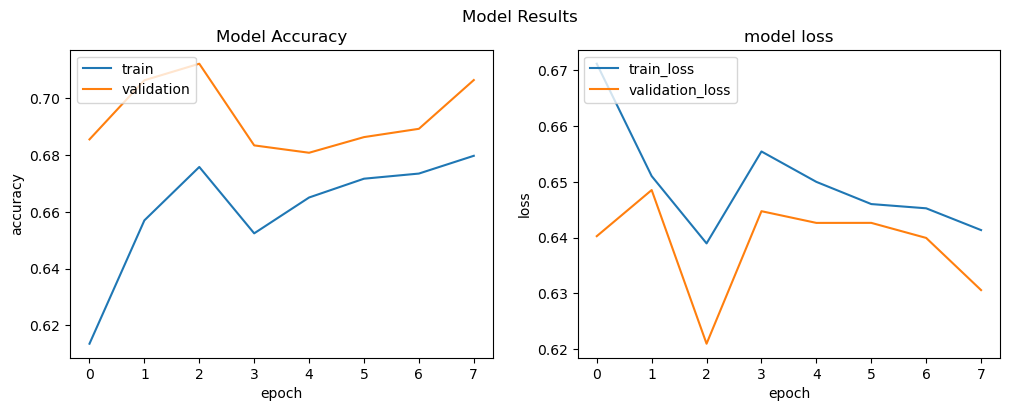

In [47]:
visualize(hist)

In [48]:
y_pred = model.predict(
    gen_batch(test_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_10.csv')

#Kaggle 69.1%

771/771 [==============================] - 11s 14ms/step


Observation: looks like Relational Graph networks don't perform well on this kind of data since we haven't had a good performing model for the past five trials so it's recomended something different in the future
### the highest performing model is GNN with upsampling